In [1]:
# Cell 1: Imports, Load Backtest Logs, AND Load Training Input Features

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import glob
import re
import json # For loading feature columns if needed

# --- Configuration for Backtest Log Analysis ---
# Assuming eda.ipynb is in /Users/omarabul-hassan/Desktop/projects/kalshi/notebooks/train/
current_notebook_dir = Path.cwd() # This will be .../kalshi/notebooks/train
# LOGS_PARENT_DIR should point to .../kalshi/notebooks/logs
LOGS_PARENT_DIR = current_notebook_dir.parent.parent / "notebooks" / "logs" # Adjusted to go up two levels then into notebooks/logs
# Or, if your project structure is flat within 'kalshi' and 'notebooks' is a direct child:
# LOGS_PARENT_DIR = current_notebook_dir.parent.parent / "logs" # if 'train' is inside 'notebooks' which is inside 'kalshi'

# Let's be more explicit based on your provided path for features:
PROJECT_ROOT_DIR = Path("/Users/omarabul-hassan/Desktop/projects/kalshi")
LOGS_PARENT_DIR = PROJECT_ROOT_DIR / "notebooks" / "logs"
FEATURES_INPUT_DIR = PROJECT_ROOT_DIR / "notebooks" / "features"
TRAINED_MODELS_DIR = PROJECT_ROOT_DIR / "notebooks" / "trained_models" / "logreg"


print(f"PROJECT_ROOT_DIR: {PROJECT_ROOT_DIR.resolve()}")
print(f"LOGS_PARENT_DIR: {LOGS_PARENT_DIR.resolve()}")
print(f"FEATURES_INPUT_DIR: {FEATURES_INPUT_DIR.resolve()}")
print(f"TRAINED_MODELS_DIR: {TRAINED_MODELS_DIR.resolve()}")


MODEL_TYPE_LOG_SUBDIR_NAME = "backtest_logreg_calibrated_v2_15m_offset"
print(f"Expecting detailed logs in subdir: {MODEL_TYPE_LOG_SUBDIR_NAME}")

# --- STRATEGY PARAMETERS (Manually set to match the backtest run being analyzed) ---
# These should match the values used in the backtest_classifier_v1.py run that produced the logs
# From your previous EDA output, these were:
STRATEGY_MIN_MODEL_PROB_FOR_CONSIDERATION = 0.60
STRATEGY_EDGE_THRESHOLD_FOR_TRADE = 0.10
# IF YOU RE-RAN THE BACKTEST WITH DIFFERENT PARAMS (e.g., P_model=0.85), UPDATE THESE!
print(f"Using for EDA (from backtest params): STRATEGY_MIN_MODEL_PROB_FOR_CONSIDERATION = {STRATEGY_MIN_MODEL_PROB_FOR_CONSIDERATION}")
print(f"Using for EDA (from backtest params): STRATEGY_EDGE_THRESHOLD_FOR_TRADE = {STRATEGY_EDGE_THRESHOLD_FOR_TRADE}")


# --- Load Main Aggregated Trades File (from backtest) ---
all_trades_files_pattern = "ALL_TRADES_WITH_EVALS_*.csv"
# Ensure LOGS_PARENT_DIR is correct for this glob
all_trades_files = sorted(LOGS_PARENT_DIR.glob(all_trades_files_pattern), key=os.path.getctime, reverse=True)

df_all_decisions = pd.DataFrame()
ALL_TRADES_CSV_PATH = None
run_ts_from_filename = None # This will be the timestamp from the ALL_TRADES_WITH_EVALS filename

if not all_trades_files:
    print(f"ERROR: No '{all_trades_files_pattern}' file found in {LOGS_PARENT_DIR.resolve()}")
else:
    ALL_TRADES_CSV_PATH = all_trades_files[0]
    if ALL_TRADES_CSV_PATH:
        print(f"Loading main decision log: {ALL_TRADES_CSV_PATH}")
        try:
            df_all_decisions = pd.read_csv(ALL_TRADES_CSV_PATH)
            df_all_decisions['decision_timestamp_utc'] = pd.to_datetime(df_all_decisions['decision_timestamp_utc'])
            print(f"Loaded {len(df_all_decisions)} total decision records from main log.")

            filename_stem = Path(ALL_TRADES_CSV_PATH).stem
            match_ts = re.search(r'(\d{8}_\d{6})', filename_stem)
            if match_ts:
                run_ts_from_filename = match_ts.group(1)
                print(f"Extracted run_ts_from_filename: {run_ts_from_filename}")
            else:
                parts = filename_stem.split('_')
                if len(parts) > 1 and re.match(r'\d{8}_\d{6}', parts[-1]):
                    run_ts_from_filename = parts[-1]
                    print(f"Extracted run_ts_from_filename (fallback): {run_ts_from_filename}")
                else:
                    print(f"WARNING: Could not robustly parse timestamp from '{filename_stem}'. Timestamp matching for detailed logs might be affected.")
                    # Example: run_ts_from_filename = "20250521_235341" # Manually set if needed AND if you are sure

        except Exception as e:
            print(f"Error loading {ALL_TRADES_CSV_PATH}: {e}")
            df_all_decisions = pd.DataFrame()
    else:
        print(f"ERROR: Could not determine a suitable '{all_trades_files_pattern}' file.")


# --- Load and Merge Detailed Decision Evaluation Logs (from backtest) ---
df_eval_details = pd.DataFrame()
if not df_all_decisions.empty and run_ts_from_filename:
    print(f"Using run_timestamp '{run_ts_from_filename}' for finding decision_eval_logs.")
    decision_eval_log_specific_dir = LOGS_PARENT_DIR / MODEL_TYPE_LOG_SUBDIR_NAME
    eval_log_pattern = f"decision_eval_log_*_random_forest_{run_ts_from_filename}.csv"
    print(f"Looking for decision_eval_log files in: {decision_eval_log_specific_dir.resolve()}")
    print(f"Using pattern: {eval_log_pattern}")
    decision_eval_files = sorted(list(decision_eval_log_specific_dir.glob(eval_log_pattern)))

    if not decision_eval_files:
        print(f"WARNING: No '{eval_log_pattern}' files found in {decision_eval_log_specific_dir.resolve()}")
    else:
        print(f"Found {len(decision_eval_files)} decision_eval_log files to merge.")
        df_list = []
        for f_path in decision_eval_files:
            try:
                df_temp = pd.read_csv(f_path)
                df_list.append(df_temp)
            except Exception as e: print(f"Error loading {f_path}: {e}")
        if df_list:
            df_eval_details = pd.concat(df_list, ignore_index=True)
            # Ensure 'decision_dt_utc' column is datetime
            if 'decision_dt_utc' in df_eval_details.columns:
                 df_eval_details['decision_dt_utc'] = pd.to_datetime(df_eval_details['decision_dt_utc'])
            else:
                print("WARNING: 'decision_dt_utc' missing in df_eval_details. Merge might fail or be incomplete.")
            
            print(f"Loaded and combined {len(df_eval_details)} records from decision_eval_logs.")

            eval_cols_to_merge = ['decision_dt_utc', 'market_ticker', 'implied_proba_yes_at_ask',
                                  'edge_for_yes', 'predicted_proba_no', 'implied_proba_no_at_bid',
                                  'edge_for_no', 'considered_action']
            
            # Check which of these columns actually exist in df_eval_details before trying to select them
            existing_eval_cols_to_merge = [col for col in eval_cols_to_merge if col in df_eval_details.columns]
            missing_cols = set(eval_cols_to_merge) - set(existing_eval_cols_to_merge)
            if missing_cols:
                print(f"Warning: The following columns were expected but not found in df_eval_details and will not be merged: {missing_cols}")

            if 'decision_dt_utc' not in existing_eval_cols_to_merge and 'decision_dt_utc' in df_eval_details.columns: # Ensure merge keys are present
                 existing_eval_cols_to_merge = ['decision_dt_utc', 'market_ticker'] + [c for c in existing_eval_cols_to_merge if c not in ['decision_dt_utc', 'market_ticker']]


            if existing_eval_cols_to_merge and 'decision_dt_utc' in existing_eval_cols_to_merge and 'market_ticker' in existing_eval_cols_to_merge:
                df_all_decisions = pd.merge(
                    df_all_decisions,
                    df_eval_details[existing_eval_cols_to_merge], # Only use existing columns
                    left_on=['decision_timestamp_utc', 'market_ticker'],
                    right_on=['decision_dt_utc', 'market_ticker'],
                    how='left',
                    suffixes=('', '_eval')
                )
                
                # Cleanup after merge
                if 'decision_dt_utc_eval' in df_all_decisions.columns:
                     df_all_decisions.drop(columns=['decision_dt_utc_eval'], inplace=True)
                elif 'decision_dt_utc' in df_all_decisions.columns and 'decision_dt_utc' in df_eval_details.columns and df_all_decisions.columns.tolist().count('decision_dt_utc') > 1:
                     df_all_decisions = df_all_decisions.loc[:,~df_all_decisions.columns.duplicated(keep='first')]


                if 'considered_action_eval' in df_all_decisions.columns:
                    df_all_decisions['considered_action'] = df_all_decisions['considered_action_eval'].fillna(df_all_decisions['considered_action'])
                    df_all_decisions.drop(columns=['considered_action_eval'], inplace=True)
                elif 'considered_action' not in df_all_decisions.columns and 'considered_action' in existing_eval_cols_to_merge:
                     # This case should not happen if merge was successful and 'considered_action' was in eval_details
                     pass


                print(f"Merged df_eval_details (edge info) into df_all_decisions. New shape: {df_all_decisions.shape}")
                newly_added_cols_from_eval_check = ['implied_proba_yes_at_ask', 'edge_for_yes', 'predicted_proba_no', 'implied_proba_no_at_bid', 'edge_for_no', 'considered_action']
                for col in newly_added_cols_from_eval_check:
                    if col in df_all_decisions.columns:
                        print(f"Column '{col}' present after merge. Non-NaN count: {df_all_decisions[col].notna().sum()}")
                    else:
                         print(f"INFO: Column '{col}' was not part of the merge or was dropped.")
            else:
                print("Could not perform merge with df_eval_details due to missing key columns ('decision_dt_utc', 'market_ticker') in selected eval columns.")
        else:
            print("No data loaded from decision_eval_logs, df_eval_details is empty.")
elif not df_all_decisions.empty:
    print(f"WARNING: run_ts_from_filename issue ('{run_ts_from_filename}'). Skipping merge of detailed eval logs.")


# --- Load and Merge Input Features from Training Data ---
PATH_TO_TRAINING_FEATURES_CSV = FEATURES_INPUT_DIR / "kalshi_btc_features_target_v2_filtered_15m_20250521_163917.csv"

df_input_features = pd.DataFrame()
model_input_feature_names = [] # Define globally for later cells

if PATH_TO_TRAINING_FEATURES_CSV.exists():
    print(f"Loading training input features from: {PATH_TO_TRAINING_FEATURES_CSV}")
    try:
        df_input_features = pd.read_csv(PATH_TO_TRAINING_FEATURES_CSV)
        if 'decision_point_ts_utc' in df_input_features.columns:
            df_input_features['decision_point_ts_utc'] = pd.to_datetime(df_input_features['decision_point_ts_utc'], unit='s', utc=True)
            print(f"Loaded {len(df_input_features)} records with {len(df_input_features.columns)} columns from training features CSV.")

            # --- Merge input features into df_all_decisions ---
            if not df_all_decisions.empty:
                feature_cols_json_path = TRAINED_MODELS_DIR / "feature_columns_classifier_v2.json"
                if feature_cols_json_path.exists():
                    with open(feature_cols_json_path, 'r') as f:
                        model_input_feature_names = json.load(f)
                    print(f"Loaded {len(model_input_feature_names)} model input feature names from JSON: {feature_cols_json_path}")
                else:
                    print(f"WARNING: {feature_cols_json_path} not found. Attempting to infer feature columns.")
                    # Infer feature columns (less robust)
                    excluded_cols_infer = ['kalshi_market_ticker', 'decision_point_ts_utc', 'kalshi_strike_price', 
                                           'TARGET_btc_diff_from_strike', 'TARGET_market_resolves_yes']
                    model_input_feature_names = [col for col in df_input_features.columns if col not in excluded_cols_infer]
                    print(f"Inferred {len(model_input_feature_names)} model input feature names.")


                cols_to_select_from_input_features = ['decision_point_ts_utc', 'kalshi_market_ticker'] + \
                                                     [col for col in model_input_feature_names if col in df_input_features.columns]
                
                # Ensure no duplicate columns in selection other than merge keys
                unique_cols_to_select = []
                for col in cols_to_select_from_input_features:
                    if col not in unique_cols_to_select:
                        unique_cols_to_select.append(col)
                df_input_features_subset = df_input_features[unique_cols_to_select].copy()


                original_decision_cols = df_all_decisions.columns.tolist()
                
                # Before merging, check for existing columns from model_input_feature_names in df_all_decisions
                # This can happen if columns were somehow added from df_eval_details with same names
                conflicting_cols = [col for col in model_input_feature_names if col in df_all_decisions.columns and col not in ['decision_timestamp_utc', 'market_ticker']]
                if conflicting_cols:
                    print(f"Warning: The following input feature names already exist in df_all_decisions from previous merges: {conflicting_cols}. They will be overwritten or suffixed.")
                    # Optionally, rename them in df_all_decisions before merge:
                    # df_all_decisions.rename(columns={c: c + '_from_eval' for c in conflicting_cols}, inplace=True)


                df_all_decisions = pd.merge(
                    df_all_decisions,
                    df_input_features_subset,
                    left_on=['decision_timestamp_utc', 'market_ticker'],
                    right_on=['decision_point_ts_utc', 'kalshi_market_ticker'],
                    how='left',
                    suffixes=('', '_feat_input')
                )
                print(f"Shape of df_all_decisions after merging input features: {df_all_decisions.shape}")

                # Clean up merge artifacts
                if 'decision_point_ts_utc_feat_input' in df_all_decisions.columns: # Should not happen with current suffixes logic
                    df_all_decisions.drop(columns=['decision_point_ts_utc_feat_input'], inplace=True)
                if 'kalshi_market_ticker_feat_input' in df_all_decisions.columns:
                    df_all_decisions.drop(columns=['kalshi_market_ticker_feat_input'], inplace=True)
                # Drop the original decision_point_ts_utc from the right DF if it wasn't used as a suffix target
                if 'decision_point_ts_utc' in df_all_decisions.columns and df_all_decisions.columns.tolist().count('decision_point_ts_utc') > 1:
                     # Keep the one from the left table (df_all_decisions's original 'decision_timestamp_utc')
                     # This can be tricky. A safer way is to ensure `decision_timestamp_utc` is primary.
                     # The current suffixes=('', '_feat_input') means original cols from left are unsuffixed.
                     # So if 'decision_point_ts_utc' came from right, it might be 'decision_point_ts_utc_feat_input' or just 'decision_point_ts_utc'
                     # if there was no conflict.
                     # Let's ensure `decision_timestamp_utc` is the one we use, and `decision_point_ts_utc` (if it's a separate col from right) is dropped.
                     if 'decision_point_ts_utc' in df_all_decisions.columns and 'decision_timestamp_utc' in df_all_decisions.columns and 'decision_point_ts_utc' != 'decision_timestamp_utc':
                         #This check is if 'decision_point_ts_utc' was NOT part of the original df_all_decisions
                         cols_list = df_all_decisions.columns.tolist()
                         if cols_list.count('decision_point_ts_utc') > 0 and cols_list.count('decision_timestamp_utc') > 0 :
                             if 'decision_point_ts_utc_feat_input' not in cols_list : # if it wasn't suffixed
                                 # find the index of the second 'decision_point_ts_utc' if not suffixed
                                 # This part is tricky and depends on exact pre-merge columns.
                                 # A simpler way is to drop 'decision_point_ts_utc' if it's an extra from the merge.
                                 pass # Rely on general duplicate removal below if needed.


                # General duplicate column handling (e.g. if kalshi_strike_price was in both)
                df_all_decisions = df_all_decisions.loc[:,~df_all_decisions.columns.duplicated(keep='first')]
                print(f"Shape after removing duplicated columns post-feature-merge: {df_all_decisions.shape}")


                # Verify merge - count NaNs in a few key merged features
                print("Checking NaNs in sample merged features:")
                for col in model_input_feature_names[:5] + model_input_feature_names[-5:]: # Check first 5 and last 5 features
                    if col in df_all_decisions.columns:
                        nan_count = df_all_decisions[col].isnull().sum()
                        total_count = len(df_all_decisions)
                        if nan_count == total_count and total_count > 0:
                             print(f"  CRITICAL WARNING: Merged feature '{col}' is ALL NaNs. Merge likely failed for this column or data missing.")
                        elif nan_count > 0:
                             print(f"  Merged feature '{col}' has {nan_count} NaNs (out of {total_count}).")
                    else:
                        print(f"WARNING: Expected feature '{col}' not found after merge and duplicate removal.")
            else:
                print("df_all_decisions is empty, skipping merge with input features.")
        else:
            print(f"Feature file has no 'decision_point_ts_utc' column or it's not Unix timestamp. Cannot merge features.")
            
    except Exception as e:
        print(f"Error loading or merging training features CSV {PATH_TO_TRAINING_FEATURES_CSV}: {e}")
        df_input_features = pd.DataFrame()
else:
    print(f"Training features CSV not found at: {PATH_TO_TRAINING_FEATURES_CSV}. Cannot load input features.")


# --- Final DataFrame Info and Executed Trades Summary ---
if not df_all_decisions.empty:
    print(f"\nShape of df_all_decisions after all potential merges: {df_all_decisions.shape}")
    df_all_decisions.info(verbose=True, show_counts=True)
    # print(df_all_decisions.head().to_string()) # Can be very wide if many features merged

    df_executed_trades = df_all_decisions[
        (df_all_decisions['num_contracts_sim'] > 0) &
        (df_all_decisions['executed_trade_action'].isin(['BUY_YES', 'BUY_NO']))
    ].copy()
    print(f"\nNumber of actual executed trades: {len(df_executed_trades)}")
    if not df_executed_trades.empty:
        print("Sample of executed trades (with potentially more columns if features merged):")
        cols_to_show_initial = ['decision_timestamp_utc', 'market_ticker', 'predicted_proba_yes',
                                'executed_trade_action', 'num_contracts_sim', 'simulated_entry_price_cents',
                                'pnl_cents', 'actual_market_result', 'edge_for_yes', 'edge_for_no', 'considered_action']
        
        sample_feature_cols_to_show = []
        if model_input_feature_names: # If feature names were loaded
             sample_feature_cols_to_show = [fc for fc in model_input_feature_names[:3] + model_input_feature_names[-2:] if fc in df_executed_trades.columns] # first 3, last 2
        
        cols_to_show = cols_to_show_initial + sample_feature_cols_to_show
        
        existing_cols_to_show = [col for col in cols_to_show if col in df_executed_trades.columns]
        # Remove duplicates from existing_cols_to_show while preserving order
        seen = set()
        existing_cols_to_show = [x for x in existing_cols_to_show if not (x in seen or seen.add(x))]

        print(df_executed_trades[existing_cols_to_show].head().to_string())
else:
    print("df_all_decisions is empty. Cannot proceed with EDA.")

# Define BTC_ATR_WINDOW for Cell 7 if not already (e.g., from feature engineering script params)
if 'BTC_ATR_WINDOW' not in globals():
    BTC_ATR_WINDOW = 14 # Default, should match what was used in feature_engineering.ipynb

plt.style.use('seaborn-v0_8-whitegrid')

PROJECT_ROOT_DIR: /Users/omarabul-hassan/Desktop/projects/kalshi
LOGS_PARENT_DIR: /Users/omarabul-hassan/Desktop/projects/kalshi/notebooks/logs
FEATURES_INPUT_DIR: /Users/omarabul-hassan/Desktop/projects/kalshi/notebooks/features
TRAINED_MODELS_DIR: /Users/omarabul-hassan/Desktop/projects/kalshi/notebooks/trained_models/logreg
Expecting detailed logs in subdir: backtest_logreg_calibrated_v2_15m_offset
Using for EDA (from backtest params): STRATEGY_MIN_MODEL_PROB_FOR_CONSIDERATION = 0.6
Using for EDA (from backtest params): STRATEGY_EDGE_THRESHOLD_FOR_TRADE = 0.1
Loading main decision log: /Users/omarabul-hassan/Desktop/projects/kalshi/notebooks/logs/ALL_TRADES_WITH_EVALS_logistic_regression_20250522_024427.csv
Loaded 29074 total decision records from main log.
Extracted run_ts_from_filename: 20250522_024427
Using run_timestamp '20250522_024427' for finding decision_eval_logs.
Looking for decision_eval_log files in: /Users/omarabul-hassan/Desktop/projects/kalshi/notebooks/logs/backtest_

--- Overall Backtest Performance ---
Total P&L: $-487.11
Total Executed Trades: 582
Total Contracts Traded: 8447
Average P&L per Trade: $-0.84
Average P&L per Contract: $-0.0577

P&L by Trade Action:
executed_trade_action
BUY_YES   -487.11
Name: pnl_cents, dtype: float64

Overall Win Rate (Executed Trades): 58.42%

Win Rate by Trade Action:
executed_trade_action
BUY_YES    0.584192
Name: is_win, dtype: float64


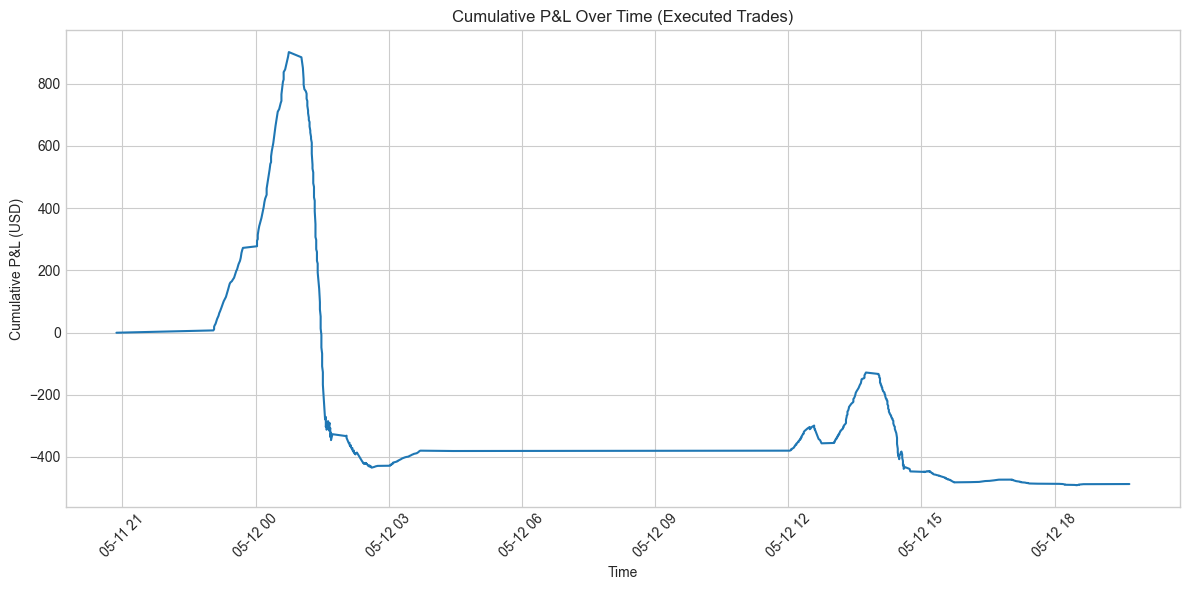

In [2]:
# Cell 2: Overall Performance Summary

if not df_all_decisions.empty and not df_executed_trades.empty:
    total_pnl = df_executed_trades['pnl_cents'].sum() / 100
    total_contracts = df_executed_trades['num_contracts_sim'].sum()
    num_trades = len(df_executed_trades)

    print(f"--- Overall Backtest Performance ---")
    print(f"Total P&L: ${total_pnl:.2f}")
    print(f"Total Executed Trades: {num_trades}")
    print(f"Total Contracts Traded: {total_contracts}")
    if num_trades > 0:
        print(f"Average P&L per Trade: ${total_pnl / num_trades:.2f}")
    if total_contracts > 0:
        print(f"Average P&L per Contract: ${total_pnl / total_contracts:.4f}")

    # P&L by Trade Action
    pnl_by_action = df_executed_trades.groupby('executed_trade_action')['pnl_cents'].sum() / 100
    print("\nP&L by Trade Action:")
    print(pnl_by_action)

    # Win/Loss Analysis
    df_executed_trades['is_win'] = np.where(df_executed_trades['pnl_cents'] > 0, 1, 0)
    win_rate = df_executed_trades['is_win'].mean()
    print(f"\nOverall Win Rate (Executed Trades): {win_rate:.2%}")

    win_rate_by_action = df_executed_trades.groupby('executed_trade_action')['is_win'].mean()
    print("\nWin Rate by Trade Action:")
    print(win_rate_by_action)
    
    # Cumulative P&L Plot
    if 'decision_timestamp_utc' in df_executed_trades.columns:
        df_executed_trades_sorted = df_executed_trades.sort_values(by='decision_timestamp_utc')
        df_executed_trades_sorted['cumulative_pnl_usd'] = df_executed_trades_sorted['pnl_cents'].cumsum() / 100
        
        plt.figure(figsize=(12, 6))
        plt.plot(df_executed_trades_sorted['decision_timestamp_utc'], df_executed_trades_sorted['cumulative_pnl_usd'])
        plt.title('Cumulative P&L Over Time (Executed Trades)')
        plt.xlabel('Time')
        plt.ylabel('Cumulative P&L (USD)')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("Skipping cumulative P&L plot as 'decision_timestamp_utc' is missing or trades are empty.")
else:
    print("No executed trades to analyze for overall performance.")

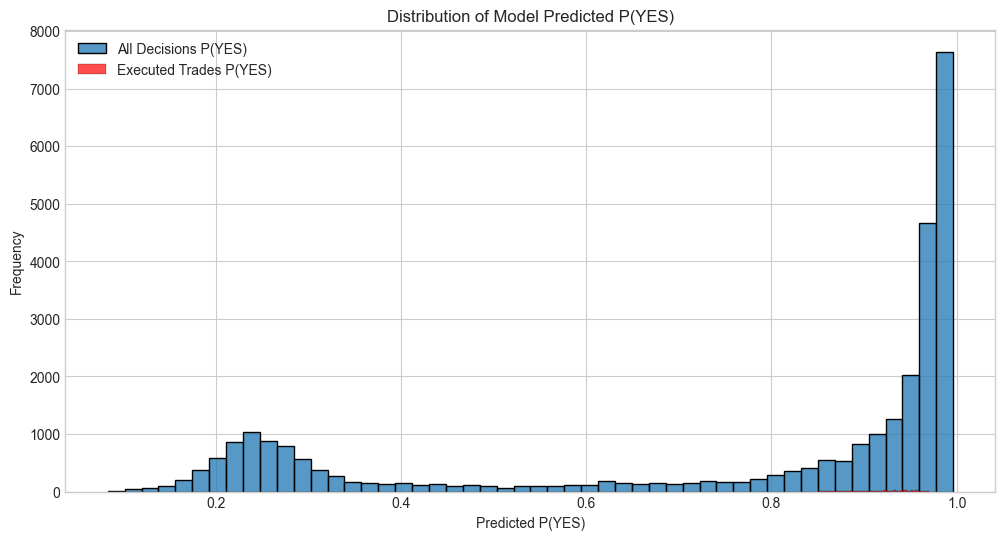


Descriptive statistics for predicted_proba_yes (All Decisions):
count    29074.000000
mean         0.759104
std          0.298666
min          0.083000
25%          0.495400
50%          0.939400
75%          0.978600
max          0.996200
Name: predicted_proba_yes, dtype: float64

Descriptive statistics for predicted_proba_yes (Executed Trades):
count    582.000000
mean       0.918775
std        0.031545
min        0.850200
25%        0.894025
50%        0.923500
75%        0.945375
max        0.969900
Name: predicted_proba_yes, dtype: float64

Edge columns ('edge_for_yes', 'edge_for_no') not found in df_all_decisions. Ensure decision_eval_logs were merged correctly in Cell 1.


In [3]:
# Cell 3: Analysis of Model Probabilities and Edge

if not df_all_decisions.empty:
    plt.figure(figsize=(12, 6))
    sns.histplot(df_all_decisions['predicted_proba_yes'].dropna(), bins=50, kde=False, label='All Decisions P(YES)')
    if not df_executed_trades.empty:
        sns.histplot(df_executed_trades['predicted_proba_yes'].dropna(), bins=50, kde=False, color='red', alpha=0.7, label='Executed Trades P(YES)')
    plt.title('Distribution of Model Predicted P(YES)')
    plt.xlabel('Predicted P(YES)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    print("\nDescriptive statistics for predicted_proba_yes (All Decisions):")
    print(df_all_decisions['predicted_proba_yes'].describe())
    
    if not df_executed_trades.empty:
        print("\nDescriptive statistics for predicted_proba_yes (Executed Trades):")
        print(df_executed_trades['predicted_proba_yes'].describe())

    edge_cols_exist = all(col in df_all_decisions.columns for col in ['edge_for_yes', 'edge_for_no'])
    if edge_cols_exist:
        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        sns.histplot(df_all_decisions['edge_for_yes'].dropna(), bins=50, kde=False, label='Edge for YES')
        if not df_executed_trades.empty and not df_executed_trades[df_executed_trades['executed_trade_action'] == 'BUY_YES'].empty: # Check if df is not empty
             sns.histplot(df_executed_trades[df_executed_trades['executed_trade_action'] == 'BUY_YES']['edge_for_yes'].dropna(), 
                          bins=20, kde=False, color='green', alpha=0.7, label='Executed BUY_YES Edge')
        plt.title('Distribution of Edge for YES')
        plt.xlabel('Edge (P_model - P_market_ask)')
        # Use the variable defined in Cell 1
        plt.axvline(STRATEGY_EDGE_THRESHOLD_FOR_TRADE, color='r', linestyle='--', label=f'Edge Threshold ({STRATEGY_EDGE_THRESHOLD_FOR_TRADE})')
        plt.legend()

        plt.subplot(1, 2, 2)
        sns.histplot(df_all_decisions['edge_for_no'].dropna(), bins=50, kde=False, label='Edge for NO')
        if not df_executed_trades.empty and not df_executed_trades[df_executed_trades['executed_trade_action'] == 'BUY_NO'].empty: # Check if df is not empty
            sns.histplot(df_executed_trades[df_executed_trades['executed_trade_action'] == 'BUY_NO']['edge_for_no'].dropna(), 
                         bins=20, kde=False, color='orange', alpha=0.7, label='Executed BUY_NO Edge')
        plt.title('Distribution of Edge for NO')
        plt.xlabel('Edge (P_model_no - P_market_no_bid)')
        # Use the variable defined in Cell 1
        plt.axvline(STRATEGY_EDGE_THRESHOLD_FOR_TRADE, color='r', linestyle='--', label=f'Edge Threshold ({STRATEGY_EDGE_THRESHOLD_FOR_TRADE})')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

        print("\nDescriptive statistics for edge_for_yes (All Decisions):")
        print(df_all_decisions['edge_for_yes'].describe())
        print("\nDescriptive statistics for edge_for_no (All Decisions):")
        print(df_all_decisions['edge_for_no'].describe())
        
        if not df_executed_trades.empty:
            if not df_executed_trades[df_executed_trades['executed_trade_action'] == 'BUY_YES'].empty:
                print("\nDescriptive statistics for edge_for_yes (Executed BUY_YES Trades):")
                print(df_executed_trades[df_executed_trades['executed_trade_action'] == 'BUY_YES']['edge_for_yes'].describe())
            else:
                print("\nNo BUY_YES trades executed to describe edge for.")
            
            if not df_executed_trades[df_executed_trades['executed_trade_action'] == 'BUY_NO'].empty:
                print("\nDescriptive statistics for edge_for_no (Executed BUY_NO Trades):")
                print(df_executed_trades[df_executed_trades['executed_trade_action'] == 'BUY_NO']['edge_for_no'].describe())
            else:
                print("\nNo BUY_NO trades executed to describe edge for.")
            
    else:
        print("\nEdge columns ('edge_for_yes', 'edge_for_no') not found in df_all_decisions. Ensure decision_eval_logs were merged correctly in Cell 1.")

else:
    print("No data in df_all_decisions for probability/edge analysis.")


--- Analysis of Non-Executed Decisions ---

Breakdown of 'executed_trade_action' (final outcome in main log):
executed_trade_action
NO_TRADE_THRESHOLD_NOT_MET    88.928252
NO_TRADE_SIZE_ZERO             9.069959
BUY_YES                        2.001789
Name: proportion, dtype: float64

--- Analysis of Executed Trades ---


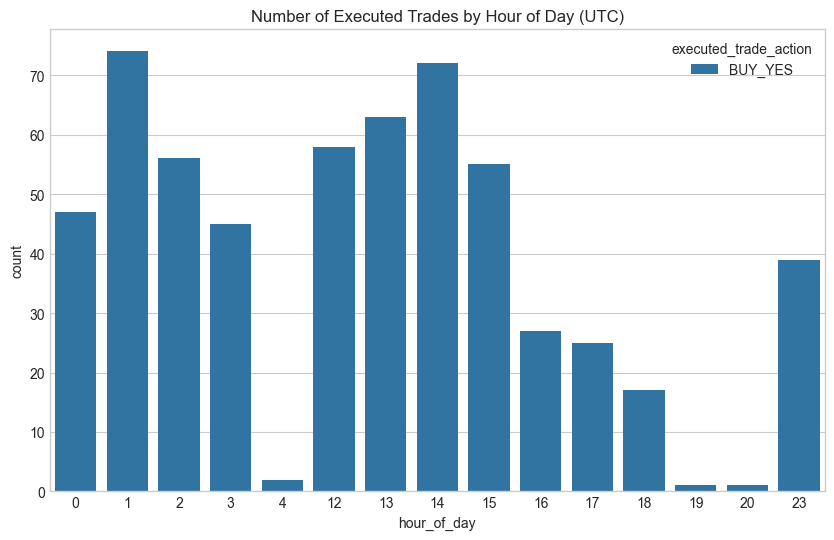

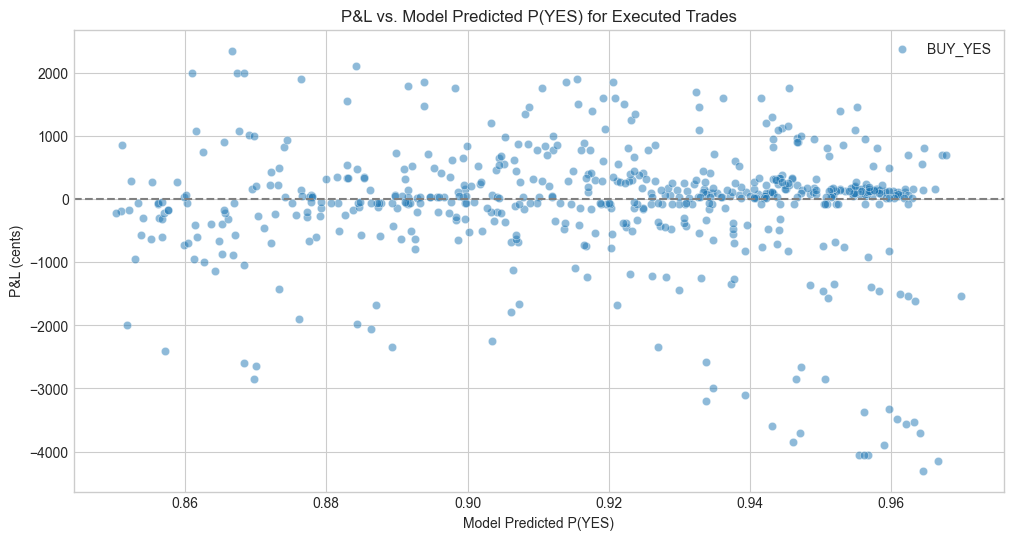

In [4]:
# Cell 4: Analysis of Trade Reasons and Market Conditions

if not df_all_decisions.empty:
    print("\n--- Analysis of Non-Executed Decisions ---")
    # executed_trade_action column in df_all_decisions will have reasons like 'NO_TRADE_THRESHOLD_NOT_MET' etc.
    # from the main trades log.
    # The 'considered_action' from df_eval_details (now merged) is more granular for the initial model output.
    
    if 'considered_action' in df_all_decisions.columns:
        print("\nBreakdown of 'considered_action' (from detailed eval logs):")
        print(df_all_decisions['considered_action'].value_counts(normalize=True) * 100)
    
    print("\nBreakdown of 'executed_trade_action' (final outcome in main log):")
    print(df_all_decisions['executed_trade_action'].value_counts(normalize=True) * 100)


    if not df_executed_trades.empty:
        print("\n--- Analysis of Executed Trades ---")
        # When are trades being made in terms of time_until_market_close_min?
        # This requires 'time_until_market_close_min' to be in your features CSV and loaded into df_all_decisions
        # If it was part of feature_vector_series, it would be a column if your training features CSV included it.
        # For this, we might need to re-extract it or ensure it's in the original CSV.
        # Let's assume 'decision_timestamp_utc' and 'market_close_time_iso' (from merge if needed) are available.
        
        # To get time_until_market_close_min for executed trades, we need market_close_time_iso
        # This would typically come from merging with an outcomes file or being part of the feature set.
        # For simplicity, let's analyze by hour of day for now.
        
        df_executed_trades['hour_of_day'] = df_executed_trades['decision_timestamp_utc'].dt.hour
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df_executed_trades, x='hour_of_day', hue='executed_trade_action')
        plt.title('Number of Executed Trades by Hour of Day (UTC)')
        plt.show()

        # P&L vs. Predicted Probability
        plt.figure(figsize=(12, 6))
        # For BUY_YES trades
        buy_yes_trades = df_executed_trades[df_executed_trades['executed_trade_action'] == 'BUY_YES']
        if not buy_yes_trades.empty:
            sns.scatterplot(data=buy_yes_trades, x='predicted_proba_yes', y='pnl_cents', alpha=0.5, label='BUY_YES')
        
        # For BUY_NO trades (plot against P(NO) = 1 - P(YES) for consistency on x-axis)
        buy_no_trades = df_executed_trades[df_executed_trades['executed_trade_action'] == 'BUY_NO'].copy()
        if not buy_no_trades.empty:
            buy_no_trades['predicted_proba_no'] = 1 - buy_no_trades['predicted_proba_yes']
            # To plot on same P(YES) scale, let's use P(YES) for x-axis for NO trades too.
            # Their PNL is based on P(NO) being correct.
            sns.scatterplot(data=buy_no_trades, x='predicted_proba_yes', y='pnl_cents', alpha=0.5, label='BUY_NO (P(YES) shown)', marker='x')

        plt.title('P&L vs. Model Predicted P(YES) for Executed Trades')
        plt.xlabel('Model Predicted P(YES)')
        plt.ylabel('P&L (cents)')
        plt.axhline(0, color='grey', linestyle='--')
        plt.legend()
        plt.show()

        # If edge columns exist, plot P&L vs Edge
        if edge_cols_exist:
            plt.figure(figsize=(14, 6))
            plt.subplot(1,2,1)
            if not buy_yes_trades.empty:
                sns.scatterplot(data=buy_yes_trades, x='edge_for_yes', y='pnl_cents', alpha=0.5)
            plt.title('BUY_YES: P&L vs. Edge for Yes')
            plt.xlabel('Edge for YES')
            plt.ylabel('P&L (cents)')
            plt.axhline(0, color='grey', linestyle='--')

            plt.subplot(1,2,2)
            if not buy_no_trades.empty:
                 sns.scatterplot(data=buy_no_trades, x='edge_for_no', y='pnl_cents', alpha=0.5)
            plt.title('BUY_NO: P&L vs. Edge for No')
            plt.xlabel('Edge for NO')
            plt.ylabel('P&L (cents)')
            plt.axhline(0, color='grey', linestyle='--')
            plt.tight_layout()
            plt.show()

    else:
        print("No executed trades to analyze for market conditions.")
else:
    print("df_all_decisions is empty. Cannot perform further EDA.")


--- Analysis of 242 Losing Trades ---
Breakdown of Losing Trades by Action:
executed_trade_action
BUY_YES    242
Name: count, dtype: int64

Descriptive Stats for P(YES) in Losing Trades:
count    242.000000
mean       0.909404
std        0.032911
min        0.850200
25%        0.882900
50%        0.912750
75%        0.934800
max        0.969900
Name: predicted_proba_yes, dtype: float64


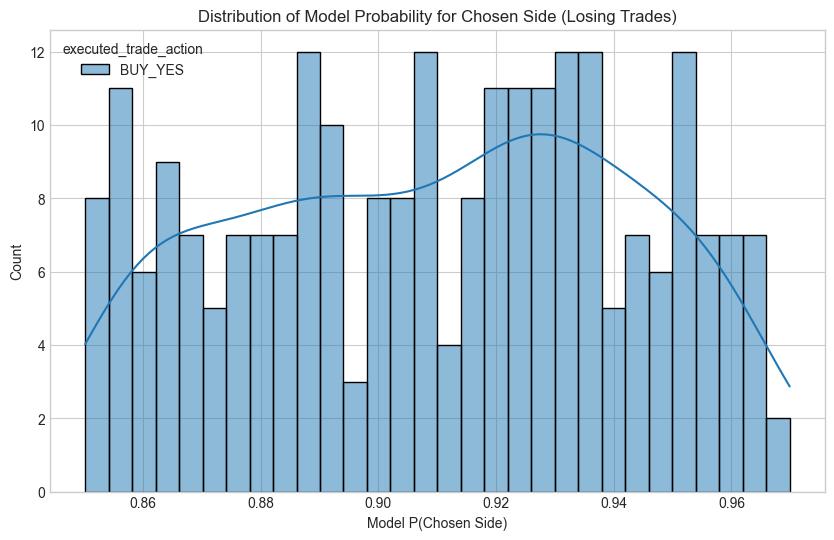


Actual Outcomes for Losing Trades:
actual_market_result    no
executed_trade_action     
BUY_YES                242

Examples of Large Losing Trades (Top 10 by Loss Amount):
        decision_timestamp_utc                market_ticker executed_trade_action  predicted_proba_yes  model_prob_chosen_side  simulated_entry_price_cents actual_market_result  pnl_cents
2281 2025-05-12 01:27:00+00:00  KXBTCD-25MAY1122-T103999.99               BUY_YES               0.9645                  0.9645                         86.0                   no    -4300.0
2275 2025-05-12 01:21:00+00:00  KXBTCD-25MAY1122-T103999.99               BUY_YES               0.9666                  0.9666                         83.0                   no    -4150.0
2283 2025-05-12 01:29:00+00:00  KXBTCD-25MAY1122-T103999.99               BUY_YES               0.9554                  0.9554                         81.0                   no    -4050.0
2284 2025-05-12 01:30:00+00:00  KXBTCD-25MAY1122-T103999.99              

In [5]:
# Cell 5: Focus on Losing Trades

if not df_executed_trades.empty:
    df_losing_trades = df_executed_trades[df_executed_trades['pnl_cents'] < 0].copy()
    print(f"\n--- Analysis of {len(df_losing_trades)} Losing Trades ---")

    if not df_losing_trades.empty:
        print("Breakdown of Losing Trades by Action:")
        print(df_losing_trades['executed_trade_action'].value_counts())

        print("\nDescriptive Stats for P(YES) in Losing Trades:")
        print(df_losing_trades['predicted_proba_yes'].describe())
        
        if edge_cols_exist:
            print("\nDescriptive Stats for Edge (YES) in Losing BUY_YES Trades:")
            print(df_losing_trades[df_losing_trades['executed_trade_action']=='BUY_YES']['edge_for_yes'].describe())
            print("\nDescriptive Stats for Edge (NO) in Losing BUY_NO Trades:")
            print(df_losing_trades[df_losing_trades['executed_trade_action']=='BUY_NO']['edge_for_no'].describe())


        # Plot P(chosen side) for losing trades
        df_losing_trades['prob_chosen_side_for_loss'] = df_losing_trades['model_prob_chosen_side']
        
        plt.figure(figsize=(10,6))
        sns.histplot(data=df_losing_trades, x='prob_chosen_side_for_loss', hue='executed_trade_action', bins=30, kde=True)
        plt.title('Distribution of Model Probability for Chosen Side (Losing Trades)')
        plt.xlabel('Model P(Chosen Side)')
        plt.show()
        
        # What was the actual outcome when we lost?
        print("\nActual Outcomes for Losing Trades:")
        print(pd.crosstab(df_losing_trades['executed_trade_action'], df_losing_trades['actual_market_result']))
        
        # Display some examples of large losses
        print("\nExamples of Large Losing Trades (Top 10 by Loss Amount):")
        print(df_losing_trades.sort_values(by='pnl_cents').head(10)[
            ['decision_timestamp_utc', 'market_ticker', 'executed_trade_action', 'predicted_proba_yes', 'model_prob_chosen_side', 'simulated_entry_price_cents', 'actual_market_result', 'pnl_cents']
        ].to_string())

    else:
        print("No losing trades to analyze.")
else:
    print("No executed trades to analyze for losses.")


--- Analysis of P(YES) Buckets (All Decisions) ---

Model P(YES) vs. Empirical P(YES) in Backtest Data:
                  total_decisions  actual_yes_outcomes  empirical_p_yes  \
proba_yes_bucket                                                          
0.00-0.10                       6                    0         0.000000   
0.10-0.20                     992                    0         0.000000   
0.20-0.30                    4475                   13         0.002905   
0.30-0.40                    1192                   44         0.036913   
0.40-0.50                     623                   86         0.138042   
0.50-0.55                     244                   56         0.229508   
0.55-0.60                     290                   39         0.134483   
0.60-0.65                     413                   53         0.128329   
0.65-0.70                     383                   73         0.190601   
0.70-0.75                     439                  108         0.24601

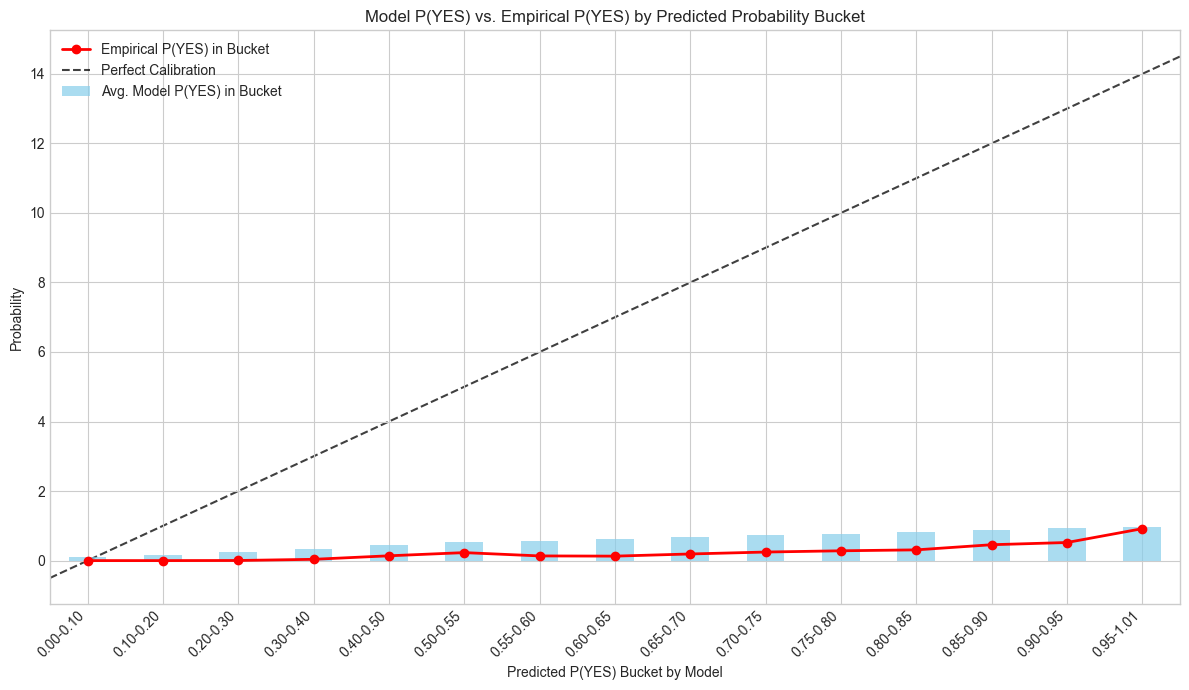


Executed trades occurred in P(YES) range: [0.8502 - 0.9699]
Could not perform actionable range analysis due to unexpected index type for buckets.


In [6]:
# Cell 6: Detailed Analysis of P(YES) Buckets

if not df_all_decisions.empty and 'predicted_proba_yes' in df_all_decisions.columns:
    print("\n--- Analysis of P(YES) Buckets (All Decisions) ---")
    
    bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.70, 0.75, 0.80, 0.85, 0.9, 0.95, 1.01] 
    labels = [f"{bins[i]:.2f}-{bins[i+1]:.2f}" for i in range(len(bins)-1)]
    df_all_decisions['proba_yes_bucket'] = pd.cut(df_all_decisions['predicted_proba_yes'], bins=bins, labels=labels, right=False, include_lowest=True)

    bucket_analysis = df_all_decisions.groupby('proba_yes_bucket', observed=False).agg(
        total_decisions=('actual_market_result', 'count'),
        actual_yes_outcomes=('actual_market_result', lambda x: (x == 'yes').sum())
    )
    bucket_analysis['empirical_p_yes'] = bucket_analysis['actual_yes_outcomes'] / bucket_analysis['total_decisions']
    bucket_analysis['avg_predicted_p_yes'] = df_all_decisions.groupby('proba_yes_bucket', observed=False)['predicted_proba_yes'].mean()

    # Handle potential NaN results from division by zero if a bucket has no decisions
    bucket_analysis.fillna(0, inplace=True)

    print("\nModel P(YES) vs. Empirical P(YES) in Backtest Data:")
    print(bucket_analysis)

    plt.figure(figsize=(12, 7))
    ax1 = bucket_analysis['avg_predicted_p_yes'].plot(kind='bar', alpha=0.7, label='Avg. Model P(YES) in Bucket', color='skyblue')
    ax2 = bucket_analysis['empirical_p_yes'].plot(kind='line', marker='o', linewidth=2, label='Empirical P(YES) in Bucket', color='red', secondary_y=False, ax=ax1) # Plot on same y-axis
    
    # Add y=x line for perfect calibration
    lims = [
        np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
        np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
    ]
    ax1.plot(lims, lims, 'k--', alpha=0.75, zorder=0, label='Perfect Calibration')


    plt.title('Model P(YES) vs. Empirical P(YES) by Predicted Probability Bucket')
    plt.xlabel('Predicted P(YES) Bucket by Model')
    plt.ylabel('Probability')
    plt.xticks(rotation=45, ha='right')
    ax1.legend(loc='upper left')
    # ax2.legend(loc='upper right') # Not needed if plotted on same axis
    plt.tight_layout()
    plt.show()

    if not df_executed_trades.empty and 'predicted_proba_yes' in df_executed_trades.columns:
        actionable_min_prob = df_executed_trades['predicted_proba_yes'].min()
        actionable_max_prob = df_executed_trades['predicted_proba_yes'].max()
        print(f"\nExecuted trades occurred in P(YES) range: [{actionable_min_prob:.4f} - {actionable_max_prob:.4f}]")
        
        # Filter buckets based on the range of executed trades
        # Accessing CategoricalIndex interval properties
        if isinstance(bucket_analysis.index, pd.CategoricalIndex) and isinstance(bucket_analysis.index.categories, pd.IntervalIndex):
            actionable_bucket_data = bucket_analysis[
                (bucket_analysis.index.categories.left >= actionable_min_prob*0.95) & 
                (bucket_analysis.index.categories.right <= actionable_max_prob*1.05)
            ]
            if not actionable_bucket_data.empty:
                print("\nCalibration in Actionable Range (approximate):")
                print(actionable_bucket_data)
            else:
                print(f"No buckets fully within the approximate actionable range based on current binning.")
        else:
            print("Could not perform actionable range analysis due to unexpected index type for buckets.")
            
else:
    print("df_all_decisions is empty or 'predicted_proba_yes' column is missing for bucket analysis.")


--- Losing BUY_YES Trades (242) ---
Losing BUY_YES - P(YES) stats:
count    242.000000
mean       0.909404
std        0.032911
min        0.850200
25%        0.882900
50%        0.912750
75%        0.934800
max        0.969900
Name: predicted_proba_yes, dtype: float64


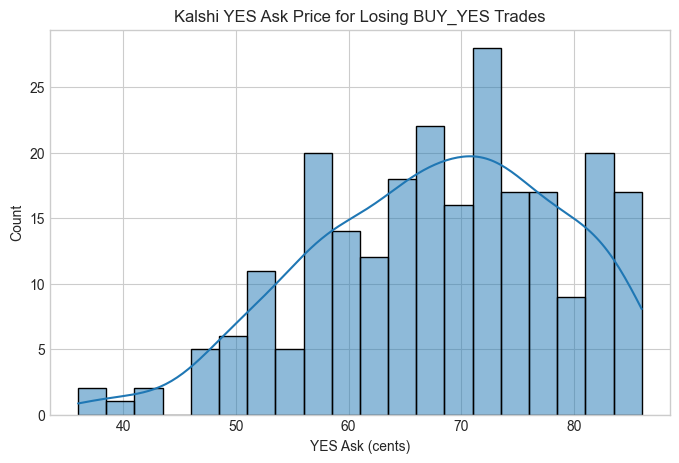


--- Winning BUY_YES Trades (340) ---
Winning BUY_YES - P(YES) stats:
count    340.000000
mean       0.925446
std        0.028777
min        0.851100
25%        0.904400
50%        0.932800
75%        0.949300
max        0.967700
Name: predicted_proba_yes, dtype: float64


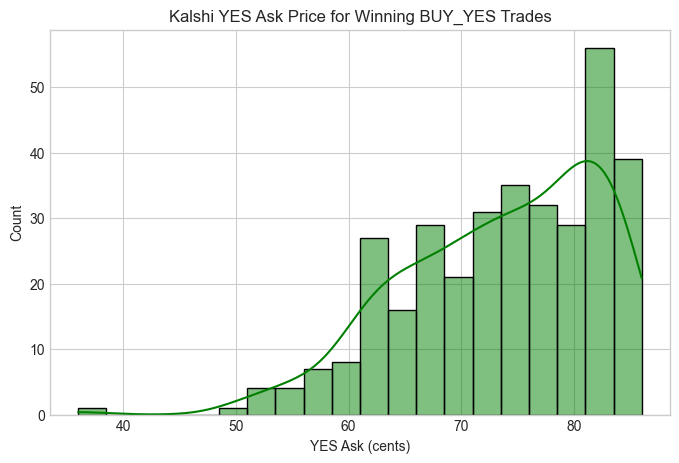


--- Decisions where model predicted P(YES) > 0.6 (21252) ---
Actual outcomes when model was confident YES (by P(YES) bucket):
actual_market_result    no    yes
proba_yes_bucket                 
0.00-0.10                0      0
0.10-0.20                0      0
0.20-0.30                0      0
0.30-0.40                0      0
0.40-0.50                0      0
0.50-0.55                0      0
0.55-0.60                0      0
0.60-0.65              360     53
0.65-0.70              310     73
0.70-0.75              331    108
0.75-0.80              382    150
0.80-0.85              681    304
0.85-0.90              894    751
0.90-0.95             1558   1689
0.95-1.01             1112  12496


In [7]:
# Cell 7: Feature Analysis for Specific Trade Outcomes

if not df_all_decisions.empty and not df_executed_trades.empty:
    # --- Compare features of Losing BUY_YES vs. Winning BUY_YES (if any) ---
    losing_buy_yes = df_executed_trades[(df_executed_trades['executed_trade_action'] == 'BUY_YES') & (df_executed_trades['pnl_cents'] < 0)]
    winning_buy_yes = df_executed_trades[(df_executed_trades['executed_trade_action'] == 'BUY_YES') & (df_executed_trades['pnl_cents'] > 0)]

    if not losing_buy_yes.empty:
        print(f"\n--- Losing BUY_YES Trades ({len(losing_buy_yes)}) ---")
        print("Losing BUY_YES - P(YES) stats:")
        print(losing_buy_yes['predicted_proba_yes'].describe())
        if 'edge_for_yes' in losing_buy_yes.columns:
            print("Losing BUY_YES - Edge for YES stats:")
            print(losing_buy_yes['edge_for_yes'].describe())
            
        if 'kalshi_yes_ask_at_decision_t' in losing_buy_yes.columns:
            plt.figure(figsize=(8,5))
            sns.histplot(losing_buy_yes['kalshi_yes_ask_at_decision_t'].dropna(), bins=20, kde=True)
            plt.title('Kalshi YES Ask Price for Losing BUY_YES Trades')
            plt.xlabel('YES Ask (cents)')
            plt.show()

    if not winning_buy_yes.empty:
        print(f"\n--- Winning BUY_YES Trades ({len(winning_buy_yes)}) ---")
        print("Winning BUY_YES - P(YES) stats:")
        print(winning_buy_yes['predicted_proba_yes'].describe())
        if 'edge_for_yes' in winning_buy_yes.columns:
            print("Winning BUY_YES - Edge for YES stats:")
            print(winning_buy_yes['edge_for_yes'].describe())
            
        if 'kalshi_yes_ask_at_decision_t' in winning_buy_yes.columns:
            plt.figure(figsize=(8,5))
            sns.histplot(winning_buy_yes['kalshi_yes_ask_at_decision_t'].dropna(), bins=20, kde=True, color='green')
            plt.title('Kalshi YES Ask Price for Winning BUY_YES Trades')
            plt.xlabel('YES Ask (cents)')
            plt.show()
    else:
        print("\nNo winning BUY_YES trades found in this backtest period.")
        
    # --- Compare high P(YES) predictions that resolved YES vs. NO ---
    # Use the variable defined in Cell 1
    high_conf_yes_preds = df_all_decisions[df_all_decisions['predicted_proba_yes'] > STRATEGY_MIN_MODEL_PROB_FOR_CONSIDERATION].copy()
    
    if not high_conf_yes_preds.empty:
        print(f"\n--- Decisions where model predicted P(YES) > {STRATEGY_MIN_MODEL_PROB_FOR_CONSIDERATION} ({len(high_conf_yes_preds)}) ---")
        
        # Ensure 'proba_yes_bucket' is available for crosstab
        if 'proba_yes_bucket' not in high_conf_yes_preds.columns and 'predicted_proba_yes' in high_conf_yes_preds.columns:
            # Re-apply binning if needed (bins/labels should be defined from Cell 6 or redefined here)
            bins_cell7 = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.70, 0.75, 0.80, 0.85, 0.9, 0.95, 1.01] 
            labels_cell7 = [f"{bins_cell7[i]:.2f}-{bins_cell7[i+1]:.2f}" for i in range(len(bins_cell7)-1)]
            high_conf_yes_preds['proba_yes_bucket'] = pd.cut(high_conf_yes_preds['predicted_proba_yes'], bins=bins_cell7, labels=labels_cell7, right=False, include_lowest=True)


        if 'proba_yes_bucket' in high_conf_yes_preds.columns:
            actual_outcomes_for_high_conf_yes = pd.crosstab(high_conf_yes_preds['proba_yes_bucket'], high_conf_yes_preds['actual_market_result'], dropna=False)
            print("Actual outcomes when model was confident YES (by P(YES) bucket):")
            print(actual_outcomes_for_high_conf_yes)
        else:
            print("Cannot create crosstab: 'proba_yes_bucket' missing from high_conf_yes_preds.")
            
    else:
        print(f"No decisions found where model predicted P(YES) > {STRATEGY_MIN_MODEL_PROB_FOR_CONSIDERATION}")

else:
    print("df_all_decisions or df_executed_trades is empty for detailed feature analysis.")


--- Analyzing Input Features for High-Confidence Predictions ---
Using HIGH_CONF_THRESHOLD for P(YES): 0.85
Number of decisions with P(YES) > 0.85: 18494
  Outcomes: 14935 actual YES, 3559 actual NO


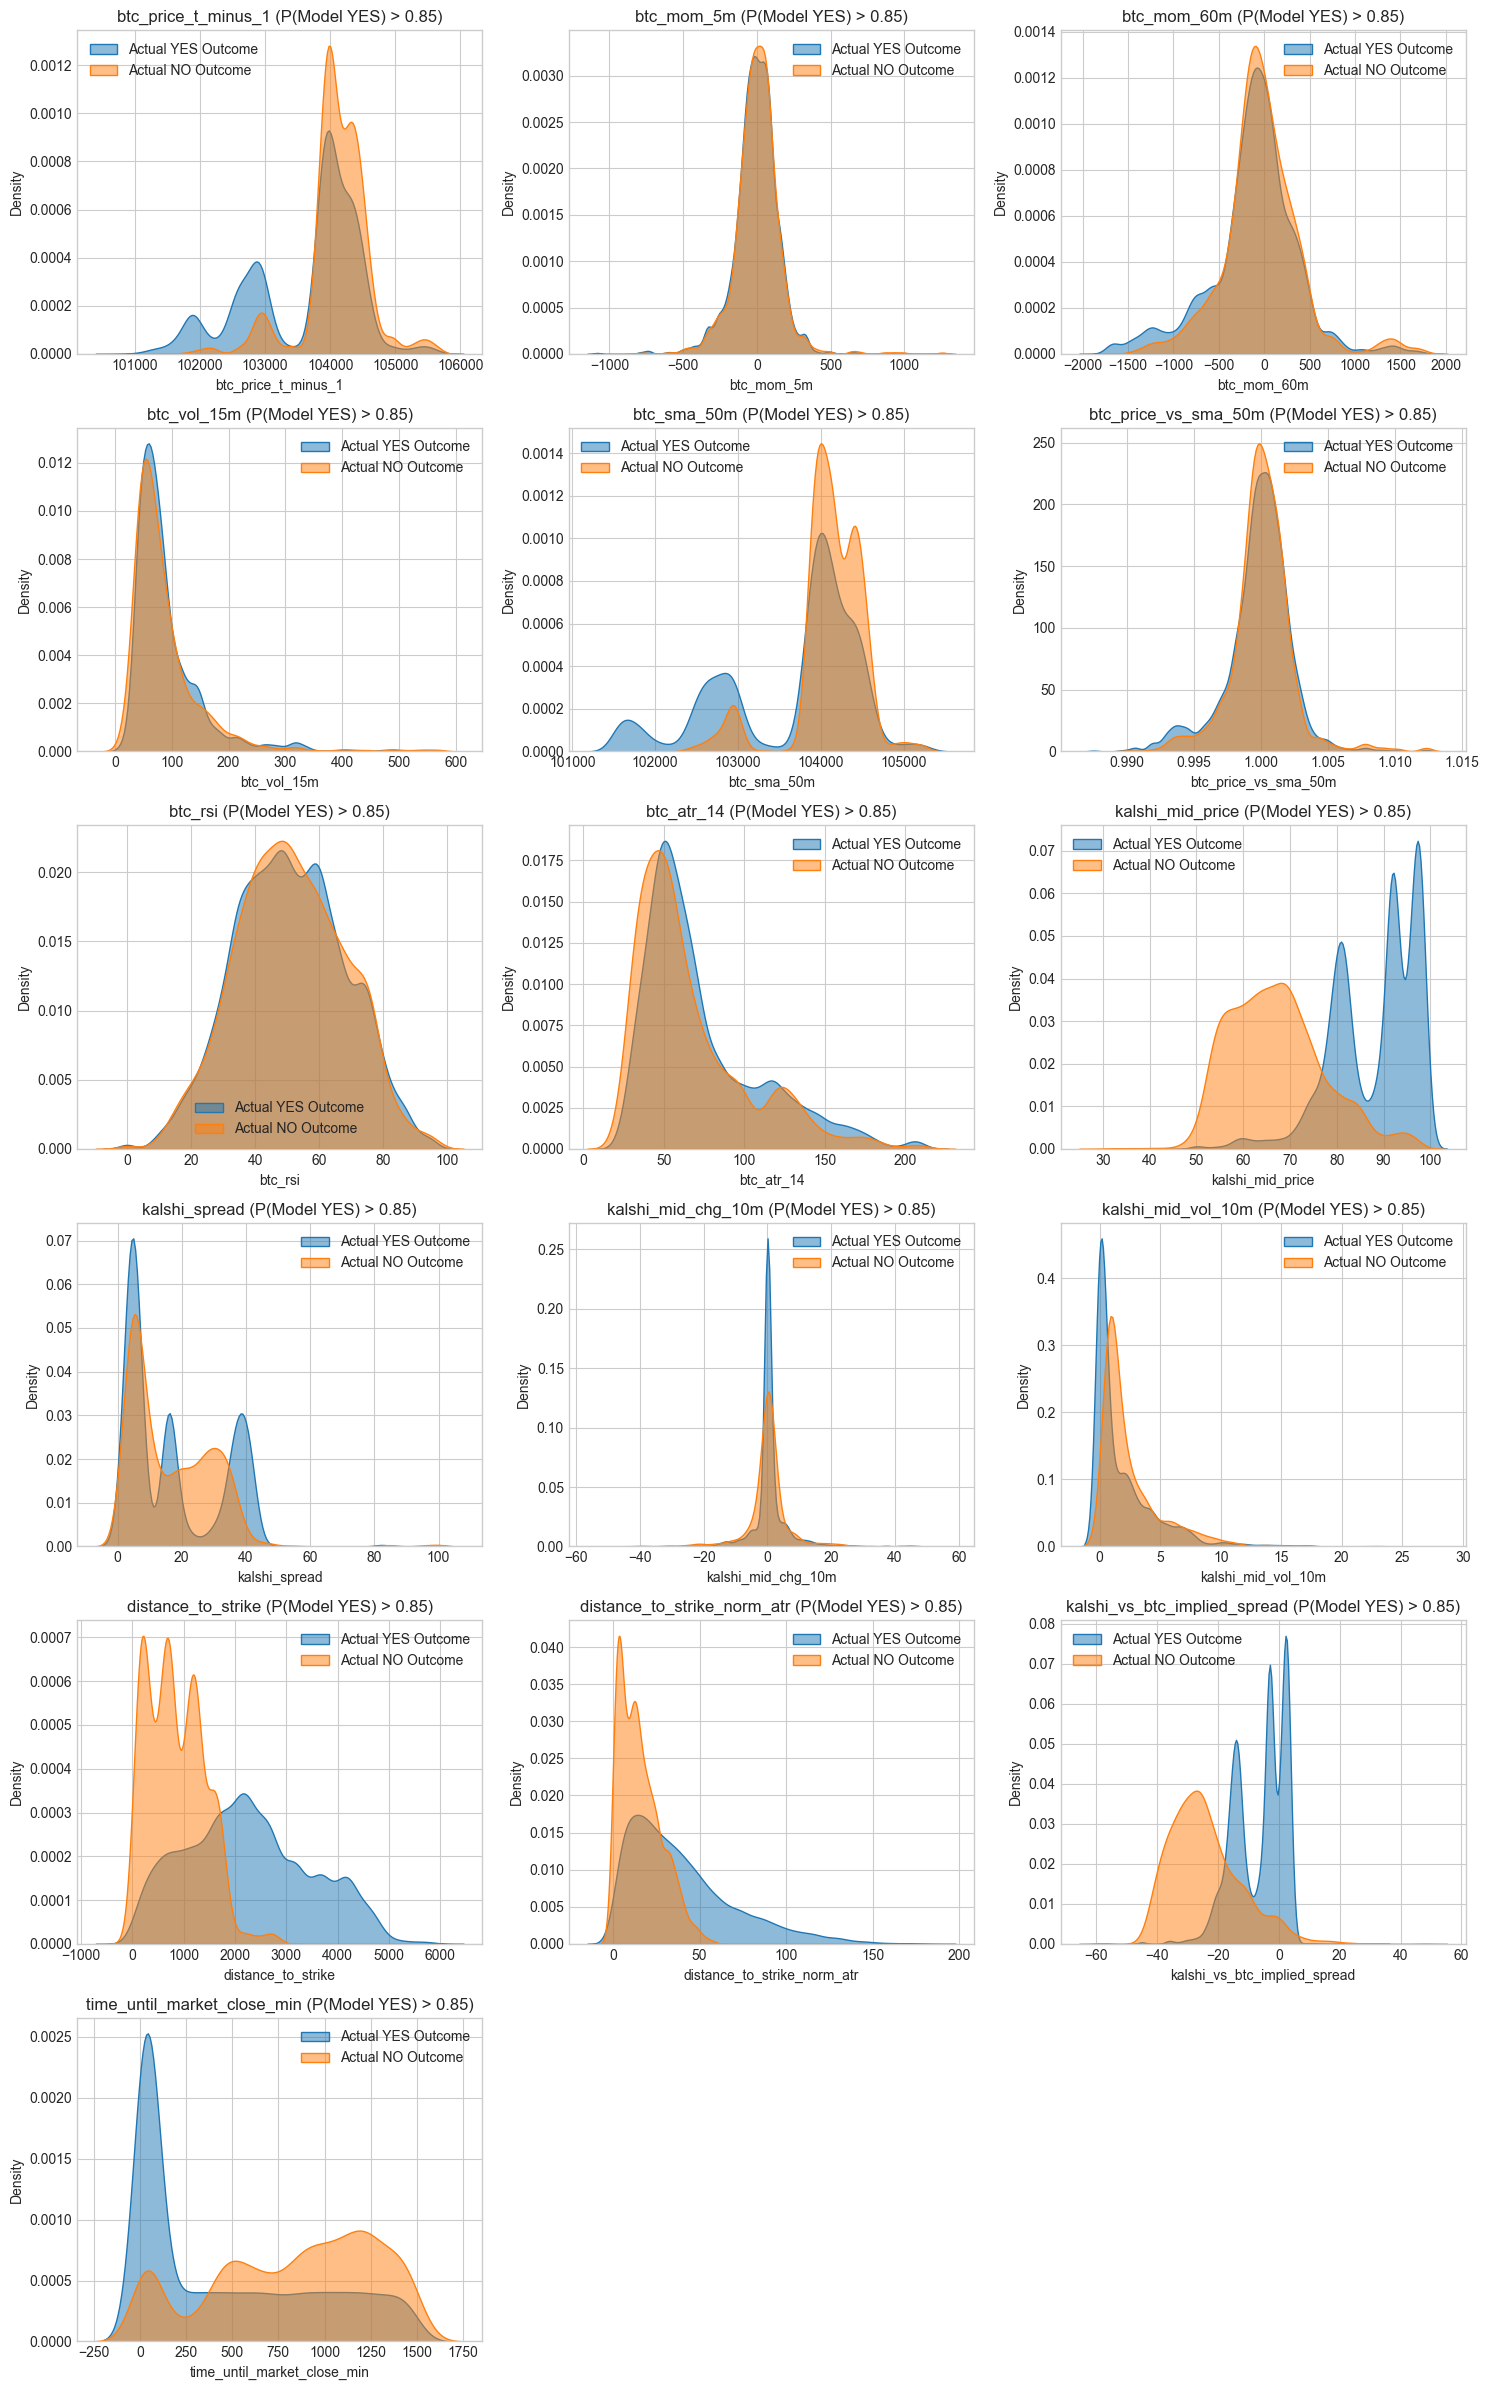


--- Descriptive Statistics for Features (P(Model YES) > 0.85) ---

Feature: btc_price_t_minus_1
          Actual_YES      Actual_NO
count   14788.000000    3554.000000
mean   103623.015821  104097.836134
std       859.369826     515.115852
min    100766.790000  101643.780000
25%    102900.010000  103926.260000
50%    103941.340000  104095.595000
75%    104238.090000  104375.240000
max    105679.010000  105679.010000

Feature: btc_mom_5m
         Actual_YES    Actual_NO
count  14710.000000  3539.000000
mean      -5.627564     2.162715
std      153.645957   157.961689
min    -1082.800000  -796.270000
25%      -78.820000   -73.900000
50%        0.100000     2.140000
75%       80.610000    77.060000
max     1255.190000  1255.190000

Feature: btc_mom_60m
         Actual_YES    Actual_NO
count  13911.000000  3326.000000
mean    -121.928977   -36.662023
std      488.769364   434.898045
min    -1821.280000 -1480.060000
25%     -319.440000  -238.280000
50%      -83.430000   -55.905000
75%     

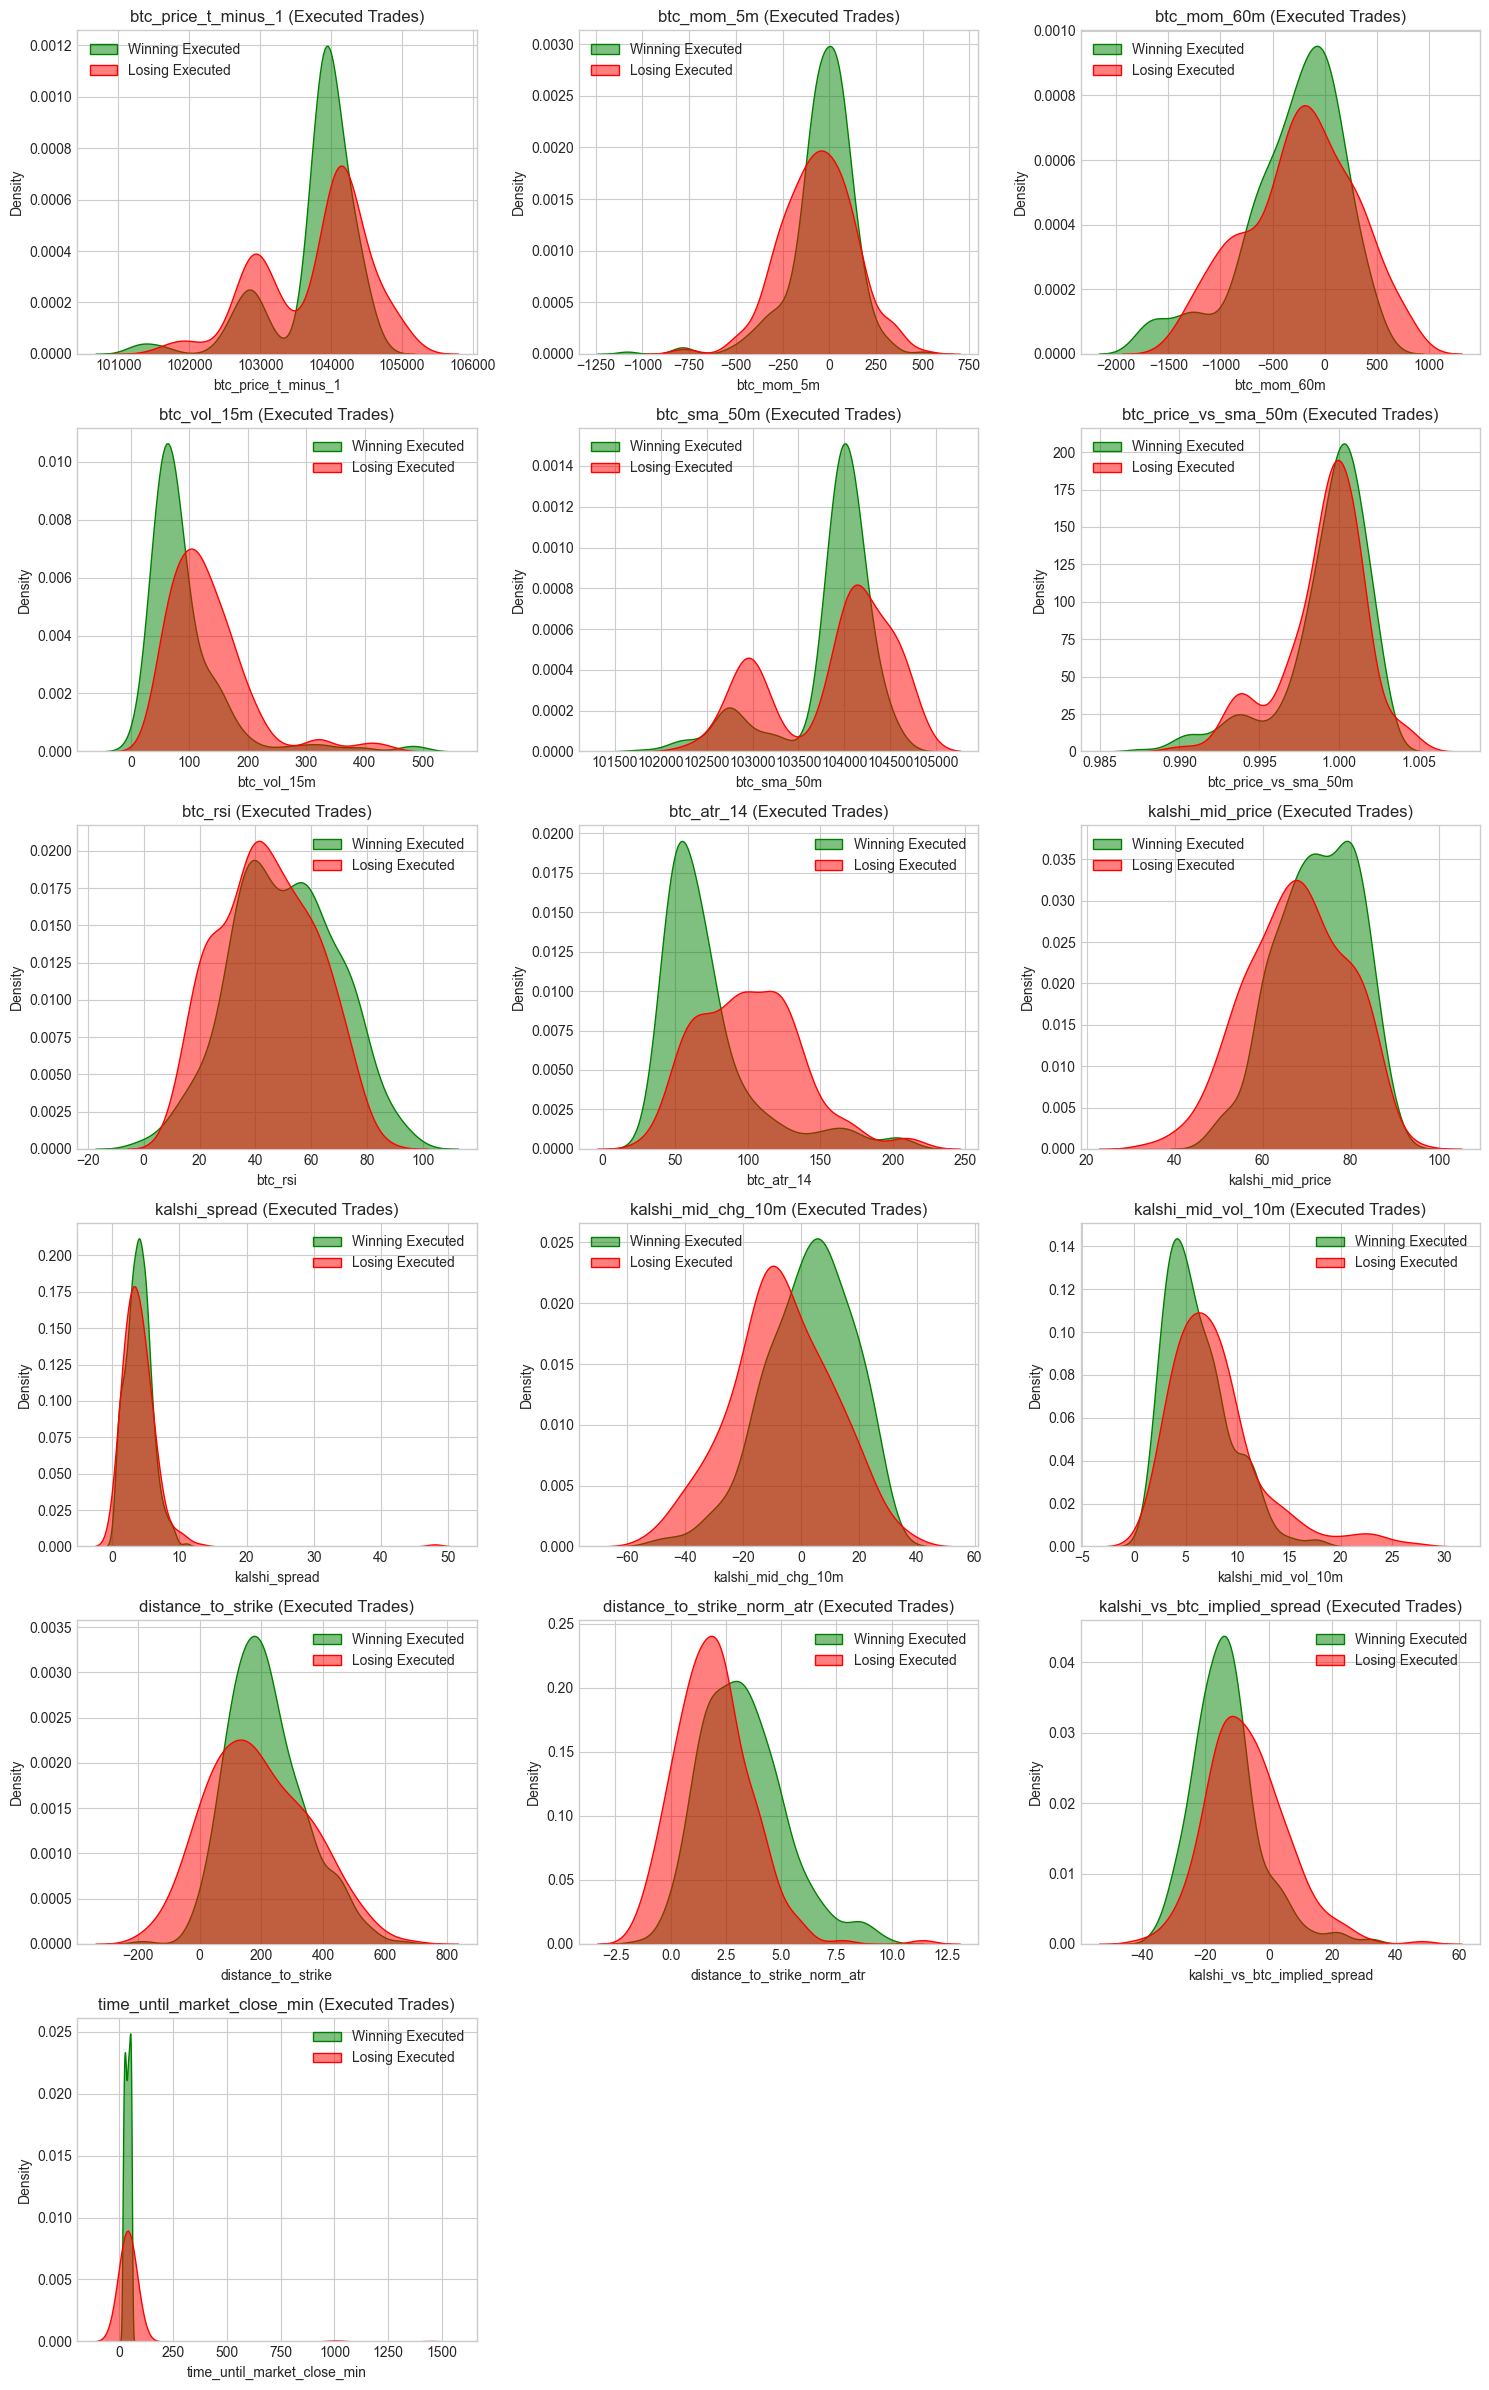


--- Descriptive Statistics for Features (Winning vs. Losing Executed Trades) ---

Feature: btc_price_t_minus_1
       Winning_Executed  Losing_Executed
count        336.000000       239.000000
mean      103764.793869    103769.706276
std          616.496228       745.106925
min       101252.010000    101643.780000
25%       103809.120000    103029.560000
50%       103919.490000    104047.610000
75%       104067.582500    104247.135000
max       104597.560000    105045.530000

Feature: btc_mom_5m
       Winning_Executed  Losing_Executed
count        330.000000       239.000000
mean         -34.602485       -62.337573
std          171.206325       196.969833
min        -1082.800000      -796.270000
25%          -96.682500      -183.990000
50%          -14.705000       -55.230000
75%           60.355000        71.805000
max          503.500000       503.500000

Feature: btc_mom_60m
       Winning_Executed  Losing_Executed
count        290.000000       239.000000
mean        -307.251828  

In [8]:
# NEW Cell 7: Analyze Input Features for High-Confidence Predictions

if 'df_all_decisions' not in globals() or df_all_decisions.empty:
    print("df_all_decisions is not available. Please run previous cells.")
elif 'model_input_feature_names' not in globals() or not model_input_feature_names:
    print("model_input_feature_names not loaded (likely feature_columns_classifier_v2.json missing or empty). Cannot perform feature analysis.")
else:
    print("\n--- Analyzing Input Features for High-Confidence Predictions ---")
    
    # Define "high confidence" threshold (can be adjusted)
    HIGH_CONF_THRESHOLD = 0.85 # Example: Only look at predictions where P(YES) > 0.85
    print(f"Using HIGH_CONF_THRESHOLD for P(YES): {HIGH_CONF_THRESHOLD}")

    df_high_conf_decisions = df_all_decisions[df_all_decisions['predicted_proba_yes'] > HIGH_CONF_THRESHOLD].copy()
    print(f"Number of decisions with P(YES) > {HIGH_CONF_THRESHOLD}: {len(df_high_conf_decisions)}")

    if not df_high_conf_decisions.empty:
        df_high_conf_yes_outcome = df_high_conf_decisions[df_high_conf_decisions['actual_market_result'] == 'yes']
        df_high_conf_no_outcome = df_high_conf_decisions[df_high_conf_decisions['actual_market_result'] == 'no']

        print(f"  Outcomes: {len(df_high_conf_yes_outcome)} actual YES, {len(df_high_conf_no_outcome)} actual NO")

        if not df_high_conf_yes_outcome.empty and not df_high_conf_no_outcome.empty:
            # --- Compare distributions of key features ---
            # Select a subset of features you suspect might be important or problematic
            # Or iterate through all model_input_feature_names if you want to be exhaustive (many plots)
            
            features_to_compare = [
                'btc_price_t_minus_1', 'btc_mom_5m', 'btc_mom_60m', 
                'btc_vol_15m', 'btc_sma_50m', 'btc_price_vs_sma_50m', 
                'btc_rsi', f'btc_atr_{BTC_ATR_WINDOW if "BTC_ATR_WINDOW" in globals() else 14}', # Use global if defined
                'kalshi_mid_price', 'kalshi_spread', 'kalshi_mid_chg_10m', 'kalshi_mid_vol_10m',
                'distance_to_strike', 'distance_to_strike_norm_atr', 
                'kalshi_vs_btc_implied_spread',
                'time_until_market_close_min'
            ]
            
            # Filter features_to_compare to only those that exist in the dataframe
            features_to_compare = [f for f in features_to_compare if f in df_high_conf_decisions.columns]
            if not features_to_compare:
                 print("WARNING: None of the selected 'features_to_compare' exist in the DataFrame. Input features might not have merged correctly.")
            
            num_features_to_plot = len(features_to_compare)
            if num_features_to_plot > 0:
                # Dynamic subplot layout
                cols_subplot = 3
                rows_subplot = (num_features_to_plot + cols_subplot - 1) // cols_subplot
                
                plt.figure(figsize=(cols_subplot * 5, rows_subplot * 4))
                for i, feature_name in enumerate(features_to_compare):
                    plt.subplot(rows_subplot, cols_subplot, i + 1)
                    sns.kdeplot(df_high_conf_yes_outcome[feature_name].dropna(), label='Actual YES Outcome', fill=True, alpha=0.5)
                    sns.kdeplot(df_high_conf_no_outcome[feature_name].dropna(), label='Actual NO Outcome', fill=True, alpha=0.5)
                    plt.title(f'{feature_name} (P(Model YES) > {HIGH_CONF_THRESHOLD})')
                    plt.legend()
                plt.tight_layout()
                plt.show()

                # --- Print descriptive statistics for comparison ---
                print(f"\n--- Descriptive Statistics for Features (P(Model YES) > {HIGH_CONF_THRESHOLD}) ---")
                for feature_name in features_to_compare:
                    print(f"\nFeature: {feature_name}")
                    stats_yes = df_high_conf_yes_outcome[feature_name].describe()
                    stats_no = df_high_conf_no_outcome[feature_name].describe()
                    comparison_stats = pd.DataFrame({'Actual_YES': stats_yes, 'Actual_NO': stats_no})
                    print(comparison_stats)
            else:
                print("No features selected or available for comparison plotting.")
        else:
            print("Not enough data for both YES and NO outcomes in high-confidence predictions to compare features.")
    else:
        print(f"No decisions found with P(YES) > {HIGH_CONF_THRESHOLD} to analyze features.")

# It's also useful to look at features of winning vs losing EXECUTED trades
if 'df_executed_trades' in globals() and not df_executed_trades.empty:
    df_winning_executed = df_executed_trades[df_executed_trades['pnl_cents'] > 0]
    df_losing_executed = df_executed_trades[df_executed_trades['pnl_cents'] < 0]

    if not df_winning_executed.empty and not df_losing_executed.empty and model_input_feature_names:
        print("\n--- Analyzing Input Features for Winning vs. Losing EXECUTED Trades ---")
        
        # Use the same features_to_compare list, or define a new one
        # features_to_compare_executed = features_to_compare # or a different list
        features_to_compare_executed = [f for f in features_to_compare if f in df_executed_trades.columns]


        num_features_to_plot_exec = len(features_to_compare_executed)
        if num_features_to_plot_exec > 0:
            cols_subplot_exec = 3
            rows_subplot_exec = (num_features_to_plot_exec + cols_subplot_exec - 1) // cols_subplot_exec
            
            plt.figure(figsize=(cols_subplot_exec * 5, rows_subplot_exec * 4))
            for i, feature_name in enumerate(features_to_compare_executed):
                plt.subplot(rows_subplot_exec, cols_subplot_exec, i + 1)
                sns.kdeplot(df_winning_executed[feature_name].dropna(), label='Winning Executed', fill=True, alpha=0.5, color='green')
                sns.kdeplot(df_losing_executed[feature_name].dropna(), label='Losing Executed', fill=True, alpha=0.5, color='red')
                plt.title(f'{feature_name} (Executed Trades)')
                plt.legend()
            plt.tight_layout()
            plt.show()

            print(f"\n--- Descriptive Statistics for Features (Winning vs. Losing Executed Trades) ---")
            for feature_name in features_to_compare_executed:
                print(f"\nFeature: {feature_name}")
                stats_win_exec = df_winning_executed[feature_name].describe()
                stats_lose_exec = df_losing_executed[feature_name].describe()
                comparison_stats_exec = pd.DataFrame({'Winning_Executed': stats_win_exec, 'Losing_Executed': stats_lose_exec})
                print(comparison_stats_exec)
        else:
            print("No features selected or available for comparison plotting for executed trades.")
    else:
        print("Not enough winning/losing executed trades or model_input_feature_names not available to compare features.")